In [1]:
#Find the min spanning tree for given set of points in space
#min J = sum over i,j (U(i,j)*D(i,j))
#such that:
#          for all i: Gi - Li = sum over j(Flow(i,j))
#          Flow(i,j) <= U(i,j)* M
#          (sum over c (U(i,c))) + U(c, i) <= N(degree)

In [2]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random

In [24]:
model = AbstractModel()
model.N = Param(mutable = True)
#Set limits on how many edges a single node can have
model.maxdegree = Param(mutable=True)
#i represents a set containing all the nodes 1, N
model.i = RangeSet(1, model.N)
#j is alias of i
model.j = Set(initialize=model.i)
#U indicates whether node i is connected to node j
model.U = Var(model.i, model.j, within=Binary, initialize=1)

model.flow = Var(model.i, model.j, bounds=(0, model.N), within=NonNegativeReals)
#G represents starting node(production/generation)
model.G = Var(bounds=(0, model.N), within=NonNegativeReals)
model.OF = Var(within=NonNegativeReals, initialize=5)

def initval(model, i):
    return random.uniform(0, 1)

model.Xloc = Param(model.i, within=NonNegativeReals, initialize=initval, mutable=True)
model.Yloc = Param(model.i, within=NonNegativeReals, initialize=initval, mutable=True)

def Rule_D(model, i, j):
    return sqrt((model.Xloc[i] - model.Xloc[j])**2 + (model.Yloc[i] - model.Yloc[j])**2)#(Eucledian Distance)
#Distance between each pair of nodes
model.D = Param(model.i, model.j, within=NonNegativeReals, initialize=Rule_D, mutable=True)

#Balance equation
def rule_C1(model, i):
    if i==1:
        return model.G-i/model.N == sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.j)
    else:
        return -i/model.N == sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.j)
model.C1 = Constraint(model.i, rule=rule_C1)

def rule_C2(model,i, j):
    return model.flow[j,i] <= model.U[i,j]*model.N
model.C2 = Constraint(model.i, model.j, rule=rule_C2)

#Degree Constraint condition
def rule_C3(model,i):
    return sum(model.U[i,c] + model.U[c,i] if i!=c else 0 for c in model.j) <= model.maxdegree
model.C3 = Constraint(model.i, rule=rule_C3)

def rule_OF(model):
    return model.OF == sum(model.U[r,c]*model.D[r,c] if r !=c else 0 for r in model.i for c in model.j)
model.C = Constraint(rule=rule_OF)

model.obj1 = Objective(expr=model.OF, sense=minimize)

In [25]:
opt = SolverFactory('glpk')

In [26]:
model.N = 10
model.maxdegree = 4
instance = model.create_instance()
results = opt.solve(instance) #solves and updates instance
print('OF= ', value(instance.obj1))

    mutable Param).  The linkage between this RangeSet and the original source
    data will be broken, so updating the data value in the future will not be
    reflected in this RangeSet.  To suppress this warning, explicitly convert
    the source data to a constant type (e.g., float, int, or immutable Param)
OF=  2.19248944904856


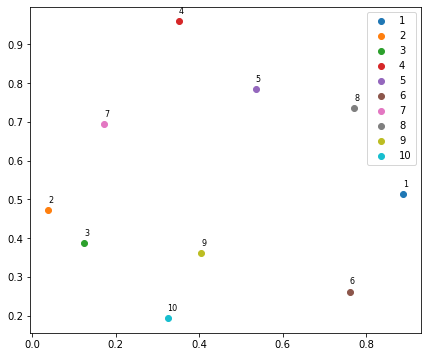

In [27]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]), value(instance.Yloc[i]), label=str(i))
    plt.text(value(instance.Xloc[i]), 0.02+value(instance.Yloc[i]), str(i), fontsize=8)
plt.legend()

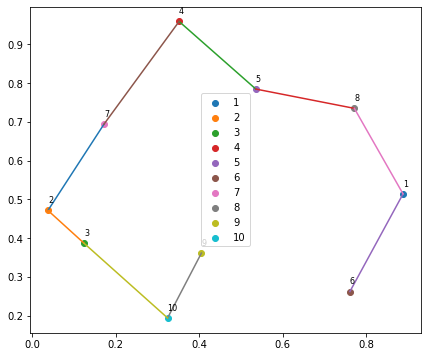

In [28]:
fig = plt.figure(figsize=(7,6))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]), value(instance.Yloc[i]), label=str(i))
    plt.text(value(instance.Xloc[i]), 0.02+value(instance.Yloc[i]), str(i), fontsize=8)
plt.legend()
for i in instance.i:
    for j in instance.j:
        if i!=j:
            if value(instance.U[i,j]) == 1:
                plt.plot([value(instance.Xloc[i]), value(instance.Xloc[j])],[value(instance.Yloc[i]),value(instance.Yloc[j])])